In [1]:
# https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/neural_operators/simple_deepOnet_in_JAX.ipynb
import matplotlib.pyplot as plt
# import neuromancer.slim as slim
import numpy as np
import torch
import torch.nn.functional as F

import sys
sys.path.append('neuromancer_deeponet/src')

from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import activations, blocks
from neuromancer.problem import Problem
from neuromancer.system import Node, System
from neuromancer.trainer import Trainer

## Current issues
* Need train/dev/test split, only have two sets currently
* Implement bias
* Test batch size

In [2]:
#data_dir = "datasets/deeponet_antiderivative_aligned"
data_dir = "examples/DeepONets/datasets"

## Prepare train data

In [3]:
# load original dataset numpy arrays
dataset_train = np.load(f"{data_dir}/antiderivative_aligned_train.npz", allow_pickle=True)

 ## Note: transposing branch input because DictDataset in Neuromancer needs all tensors in the dict to have the same shape at index 0
branch_inputs_train = dataset_train["X"][0].T
trunk_inputs_train = dataset_train["X"][1]
outputs_train = dataset_train["y"].T

print(branch_inputs_train.shape)
print(trunk_inputs_train.shape)
print(outputs_train.shape)

## Global definition of Nu and Nsamples:
## This example has 100 points (resolution of x and u(x))
## and 150 samples of functions
Nu = outputs_train.shape[0]
Nsamples = outputs_train.shape[1]
print(f'Nu = {Nu}')
print(f'Nsamples = {Nsamples}')

(100, 150)
(100, 1)
(100, 150)
Nu = 100
Nsamples = 150


In [4]:
# convert to pytorch tensors of float type
t_branch_inputs_train = torch.from_numpy(branch_inputs_train).float()
t_trunk_inputs_train = torch.from_numpy(trunk_inputs_train).float()
t_outputs_train = torch.from_numpy(outputs_train).float()

print(t_branch_inputs_train.shape)
print(t_trunk_inputs_train.shape)
print(t_outputs_train.shape)


# create named dictionary dataset
samples_train = {
    "branch_inputs": t_branch_inputs_train,
    "trunk_inputs": t_trunk_inputs_train,
    "outputs": t_outputs_train
}

train_data = DictDataset(samples_train, name="train")

torch.Size([100, 150])
torch.Size([100, 1])
torch.Size([100, 150])


In [5]:
dataset_test = np.load(f"{data_dir}/antiderivative_aligned_test.npz", allow_pickle=True)
branch_inputs_test = dataset_test["X"][0].T
trunk_inputs_test = dataset_test["X"][1]
outputs_test = dataset_test["y"].T

print(branch_inputs_test.shape)
print(trunk_inputs_test.shape)
print(outputs_test.shape)

t_branch_inputs_test = torch.from_numpy(branch_inputs_test).float()
t_reshaped_trunk_inputs_test = torch.from_numpy(trunk_inputs_test).float()
t_outputs_test = torch.from_numpy(outputs_test).float()

samples_test = {
    "branch_inputs": t_branch_inputs_test,
    "trunk_inputs": t_reshaped_trunk_inputs_test,
    "outputs": t_outputs_test
}
# create named dictionary dataset
#FIXME test_data = DictDataset(samples_test, name="test")
dev_data = DictDataset(samples_test, name="dev")

(100, 1000)
(100, 1)
(100, 1000)


In [6]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=150, collate_fn=train_data.collate_fn, shuffle=False)
#FIXME test_loader = torch.utils.data.DataLoader(test_data, batch_size=150, collate_fn=test_data.collate_fn, shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=150, collate_fn=dev_data.collate_fn, shuffle=False)

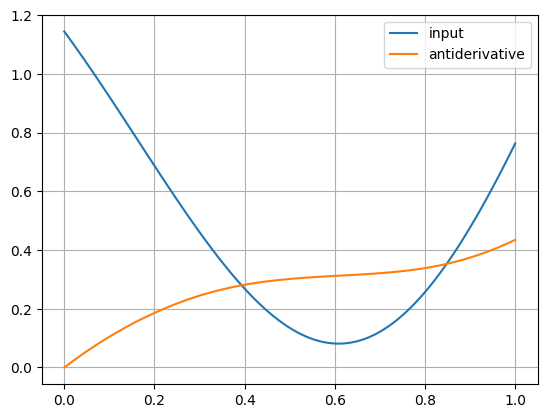

In [7]:
# Due to the dataset being aligned, we can use the trunk inputs as a grid
k = 2
plt.plot(
    train_data.datadict['trunk_inputs'],
    train_data.datadict['branch_inputs'][:,k],
    label="input",
)
plt.plot(
    train_data.datadict['trunk_inputs'],
    train_data.datadict['outputs'][:,k],
    label="antiderivative",
)
plt.legend()
plt.grid()

## Define nodes

In [8]:
train_data.datadict.keys()

dict_keys(['branch_inputs', 'trunk_inputs', 'outputs'])

In [9]:
train_data.datadict["branch_inputs"].shape

torch.Size([100, 150])

In [10]:
# Can I create a system composed of MLPS? Do I even need system or can I just wrap with nodes?
# inputs from jax example

in_size_branch = Nu
width_size = 40
depth_branch = 2
interact_size = 40
activation = torch.nn.ReLU
linear_map = torch.nn.Linear
# key?
# should bias be true? Looks like Yes, https://docs.kidger.site/equinox/api/nn/mlp/
block_branch = blocks.MLP(
    insize=in_size_branch,
    outsize=interact_size,
    bias=True,
    nonlin=activation,
    hsizes=[width_size] * depth_branch
)
branch_net = Node(block_branch, ['reshaped_branch_inputs'], ['branch_outputs'], name="branch_net")
print(branch_net.input_keys)
print(branch_net.output_keys)
print(branch_net({"reshaped_branch_inputs": t_branch_inputs_train.T}))
print(branch_net({"reshaped_branch_inputs": t_branch_inputs_train.T})['branch_outputs'].shape)


['reshaped_branch_inputs']
['branch_outputs']
{'branch_outputs': tensor([[ 0.0210, -0.0991,  0.2393,  ...,  0.0981, -0.0744,  0.0067],
        [-0.0365, -0.1152,  0.0835,  ...,  0.0593,  0.0510, -0.0137],
        [-0.0445, -0.1028,  0.1210,  ...,  0.0256,  0.0399,  0.0061],
        ...,
        [-0.0353, -0.1066,  0.1712,  ...,  0.0753, -0.0140, -0.0018],
        [-0.0176, -0.1661,  0.2306,  ...,  0.1185,  0.0042,  0.0046],
        [-0.0413, -0.1343,  0.1444,  ...,  0.0679,  0.0150, -0.0063]],
       grad_fn=<AddmmBackward0>)}
torch.Size([150, 40])


In [11]:
## Transpose for branch net
lam_transpose = lambda x_in: torch.transpose(x_in, 0, 1)
node_transpose_branch = Node(lam_transpose, ['branch_inputs'], ["reshaped_branch_inputs"], name="transpose")


In [12]:
in_size_trunk = 1
depth_trunk = 2
block_trunk = blocks.MLP(
    insize=in_size_trunk,
    outsize=interact_size,
    bias=True,
    nonlin=activation,
    hsizes= [width_size]*depth_trunk
)
trunk_net = Node(block_trunk, ["trunk_inputs"], ["trunk_outputs"], name="trunk_net")
print(trunk_net.input_keys)
print(trunk_net.output_keys)

print(trunk_net({'trunk_inputs':train_data.datadict['trunk_inputs']})["trunk_outputs"])
print(trunk_net({'trunk_inputs':train_data.datadict['trunk_inputs']})["trunk_outputs"].shape)


['trunk_inputs']
['trunk_outputs']
tensor([[-0.2136, -0.2116, -0.0713,  ..., -0.0720, -0.2138, -0.0858],
        [-0.2138, -0.2119, -0.0709,  ..., -0.0739, -0.2152, -0.0859],
        [-0.2140, -0.2121, -0.0705,  ..., -0.0758, -0.2167, -0.0860],
        ...,
        [-0.2508, -0.2819, -0.0679,  ..., -0.1781, -0.3688, -0.1352],
        [-0.2507, -0.2836, -0.0678,  ..., -0.1788, -0.3702, -0.1352],
        [-0.2505, -0.2852, -0.0678,  ..., -0.1794, -0.3716, -0.1351]],
       grad_fn=<AddmmBackward0>)
torch.Size([100, 40])


In [13]:
# bias = torch.zeros(1, requires_grad=True)
# No inputs for bias?
#node_bias = Node(bias, [], ['bias_output'], name="bias")

In [14]:
## Todo: add a bias term here
#bias = torch.rand(1,) * 1000
#bias = bias.requires_grad(True)
lam_multiply = lambda branch_output, trunk_output: torch.matmul(branch_output, trunk_output.T) #+ bias
node_multiply = Node(lam_multiply, ['branch_outputs', 'trunk_outputs'], ['g'], name="multiply_and_bias")

In [15]:
print(branch_net)
print(node_transpose_branch)
print(trunk_net)
print(node_multiply)

branch_net(reshaped_branch_inputs) -> branch_outputs
transpose(branch_inputs) -> reshaped_branch_inputs
trunk_net(trunk_inputs) -> trunk_outputs
multiply_and_bias(branch_outputs, trunk_outputs) -> g


In [16]:
## Testing all the nets to see if they are returning the expected shapes
res_transpose = node_transpose_branch({'branch_inputs':train_data.datadict['branch_inputs']})["reshaped_branch_inputs"]
res_branch = branch_net({'reshaped_branch_inputs':res_transpose})["branch_outputs"]
res_trunk = trunk_net({'trunk_inputs':train_data.datadict['trunk_inputs']})["trunk_outputs"]
res_multiply = node_multiply({'branch_outputs':res_branch, 'trunk_outputs':res_trunk})['g']
print(res_transpose.shape)
print(res_branch.shape)
print(res_trunk.shape)
print(res_multiply.shape)


torch.Size([150, 100])
torch.Size([150, 40])
torch.Size([100, 40])
torch.Size([150, 100])


In [17]:
var_y_est = variable("g")
var_y_true = variable("outputs")

nodes = [node_transpose_branch, branch_net, trunk_net, node_multiply]
#nodes = [branch_net, lam_transpose, trunk_net, lam_multiply]
# sol_map = Node(nodes, ['branch_inputs', 'reshaped_trunk_inputs'], ['branch_outputs', 'trunk_outputs'], name="map")

#var_loss = F.mse_loss(var_y_est, var_y_true)
var_loss = (var_y_est == var_y_true.T)^2
var_loss.name = "residual_loss"
objectives = [var_loss]

loss = PenaltyLoss(objectives, constraints=[])

problem = Problem(nodes, loss=loss, grad_inference=True)


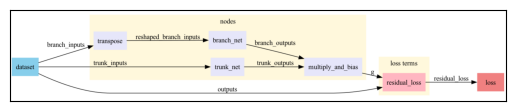

In [18]:
# brew install graphviz
problem.show()

In [19]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=1e-4, eps=1e-6)
epochs = 3000

trainer = Trainer(
    problem,
    train_data=train_loader,
    dev_data=dev_loader,
    optimizer=optimizer,
    epochs=epochs,
    epoch_verbose=100,
    train_metric='train_loss',
    dev_metric='dev_loss',
    eval_metric='dev_loss',
    warmup = epochs
)

In [20]:
best_model = trainer.train()


epoch: 0  train_loss: 0.3000396192073822
epoch: 100  train_loss: 0.02160024642944336
epoch: 200  train_loss: 0.007543626707047224
epoch: 300  train_loss: 0.0052496581338346004
epoch: 400  train_loss: 0.004050878342241049
epoch: 500  train_loss: 0.003483543638139963
epoch: 600  train_loss: 0.0030373900663107634
epoch: 700  train_loss: 0.0025359925348311663
epoch: 800  train_loss: 0.0019135120091959834
epoch: 900  train_loss: 0.0012662451481446624
epoch: 1000  train_loss: 0.0008354801684617996
epoch: 1100  train_loss: 0.0006199514027684927
epoch: 1200  train_loss: 0.0004881874774582684
epoch: 1300  train_loss: 0.0004165517748333514
epoch: 1400  train_loss: 0.00037318465183489025
epoch: 1500  train_loss: 0.00034462290932424366
epoch: 1600  train_loss: 0.00032570259645581245
epoch: 1700  train_loss: 0.00031165327527560294
epoch: 1800  train_loss: 0.00030073203379288316
epoch: 1900  train_loss: 0.0002917062374763191
epoch: 2000  train_loss: 0.00028364176978357136
epoch: 2100  train_loss: 0.

In [21]:
train_loss_history = [l.detach().numpy() for l in trainer.loss_history["train"]]
dev_loss_history = [l.detach().numpy() for l in trainer.loss_history["dev"]]

## plot loss history

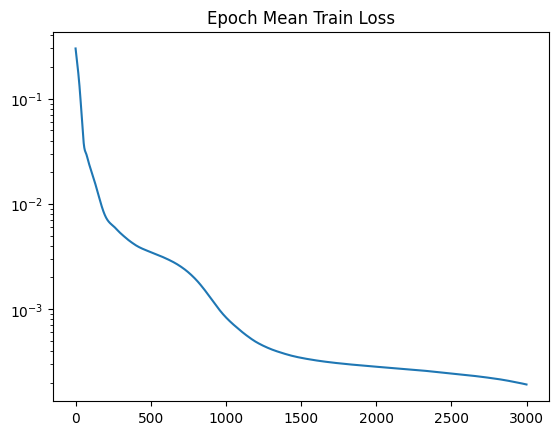

In [22]:
plt.semilogy(train_loss_history)
plt.title("Epoch Mean Train Loss")
plt.show()

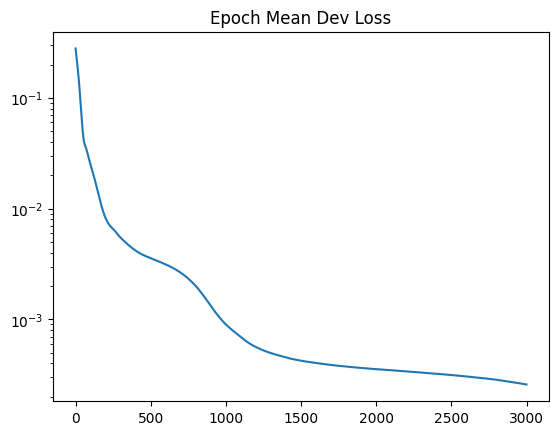

In [23]:
plt.semilogy(dev_loss_history)
plt.title("Epoch Mean Dev Loss")
plt.show()

## test trainer (need to add dev dataset)

In [24]:
#best_outputs = trainer.test(best_model)

In [25]:
# load best trained model
problem.load_state_dict(best_model)

<All keys matched successfully>

In [26]:
# (not working) Evaluate trained PINN on data (all the data in the domain)
#val_u = problem(train_data.datadict)


## Compare results

torch.Size([100, 1]) torch.Size([100, 1])


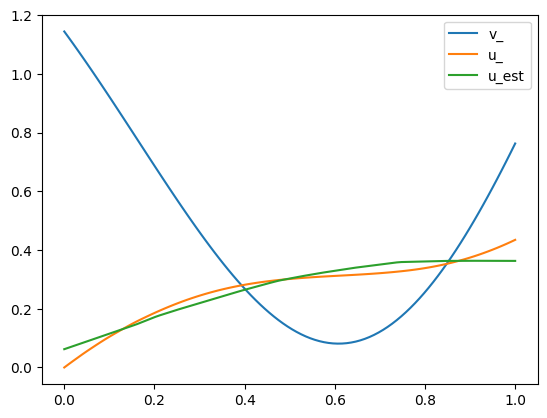

In [27]:
k = 2 # k is the k-th function among those 150 sampled v functions
#v_ = test_data.datadict["branch_inputs"][:,k].reshape(-1,1)
#x_ = test_data.datadict["trunk_inputs"]
v_ = train_data.datadict["branch_inputs"][:,k].reshape(-1,1)
x_ = train_data.datadict["trunk_inputs"]
print(v_.shape, x_.shape)


## Note: Neuromancer needs a better forward method to 'predict' after the model is trained
## This is a workaround that I found (forward pass with zero 'outputs')
## You could also use a problem.step({'branch_inputs':v_, 'trunk_inputs':x_}) here, but that is not as great
## as it computes the gradients again.
res = problem.step({'branch_inputs':v_, 'trunk_inputs':x_})

#u_ = test_data.datadict["outputs"][:,k]
u_ = train_data.datadict["outputs"][:,k]
u_est = res['g'].T

plt.plot(x_.detach().numpy(), v_.detach().numpy(),label='v_')
plt.plot(x_.detach().numpy(), u_.detach().numpy(),label='u_')
plt.plot(x_.detach().numpy(), u_est.detach().numpy(),label='u_est')

plt.legend()


torch.Size([100, 1]) torch.Size([100, 1])


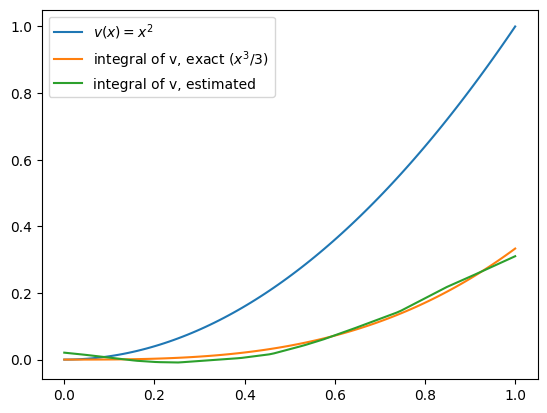

In [28]:
x_ = train_data.datadict["trunk_inputs"]
v_ = torch.pow(x_,2).reshape(-1,1)

print(v_.shape, x_.shape)
res = problem.step({'branch_inputs':v_, 'trunk_inputs':x_})

u_ = (1./3.)*torch.pow(x_,3).reshape(-1,1)
u_est = res['g'].T

plt.plot(x_.detach().numpy(), v_.detach().numpy(),label='$v(x) = x^2$')
plt.plot(x_.detach().numpy(), u_.detach().numpy(),label='integral of v, exact ($x^3/3$)')
plt.plot(x_.detach().numpy(), u_est.detach().numpy(),label='integral of v, estimated')
plt.legend()
